In [1]:
# cargar un el arhivo CSV 
# uso la opcion para cargar el archivo desde mi pc al drive

from google.colab import files

uploaded=files.upload()

Saving hotel_bookings_preprocessed.csv to hotel_bookings_preprocessed.csv


In [2]:
# abrimos el archivo prepocesado
import io
import pandas as pd


df_booking = pd.read_csv('hotel_bookings_preprocessed.csv')

# eliminamos la columna de cancel_days_before_arrival
# probar con y sin la columna
# df_booking = df_booking.drop(['cancel_days_before_arrival'], axis=1)
df_booking.head()

,Unnamed: 0,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,cancel_days_before_arrival,arrival_month_1,arrival_month_10,arrival_month_11,arrival_month_12,arrival_month_2,arrival_month_3,arrival_month_4,arrival_month_5,arrival_month_6,arrival_month_7,arrival_month_8,arrival_month_9,continent_Africa,continent_Antarctica,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,agent_b,company_b,meal_BB,meal_FB,meal_HB,meal_SC,market_seg_Aviation,market_seg_Complementary,market_seg_Corporate,market_seg_Direct,market_seg_Groups,market_seg_Offline TA/TO,market_seg_Online TA,dist_channel_Corporate,dist_channel_Direct,dist_channel_GDS,dist_channel_TA/TO,deposit_No Deposit,deposit_Non Refund,deposit_Refundable,cust_type_Contract,cust_type_Group,cust_type_Transient,cust_type_Transient-Party,adr_por_persona
0,0,0,342,0,0,2,0.0,0,0,0,0,3,0,107.675944,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,53.837972
1,1,0,737,0,0,2,0.0,0,0,0,0,4,0,107.675944,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,53.837972
2,2,0,7,0,1,1,0.0,0,0,0,0,0,0,75.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,75.000000
3,3,0,13,0,1,1,0.0,0,0,0,0,0,0,75.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,75.000000
4,4,0,0,0,2,2,0.0,0,0,0,0,0,0,107.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,53.500000


In [3]:
# balanceo de la variable target
df_booking.is_canceled.value_counts(normalize=True)

0    0.737797
1    0.262203
Name: is_canceled, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


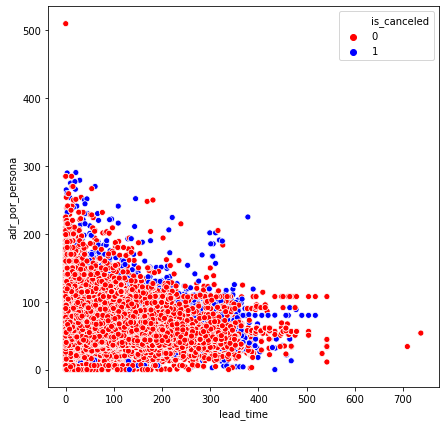

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ejemplo de grafico de dos variables y el target
plt.figure(figsize=(7,7))
sns.scatterplot(x='lead_time',y='adr_por_persona',hue='is_canceled',data=df_booking,palette={0:'red',1:'blue'})

In [5]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np


target='is_canceled'

mask = np.ones(df_booking.columns.shape, dtype=bool)
mask[0:2] = 0 #pongo false en las cols de target y indice
features=df_booking.columns[mask]

#g
# particiona el dataset manteniendo el balanceo
# 20% de los datos para usarlos como conjunto de evaluación (test set). 
# el resto para desarrollo

x_train, x_test, y_train, y_test = train_test_split(df_booking[features].values, df_booking[target].values,
                                                    test_size=0.2, random_state=42,stratify=df_booking[target].values)

print('Total: {}'.format(len(df_booking)))
print('Desarrollo 80 %: {}'.format(len(x_train)))
print('Test 20%: {}'.format(len(x_test)))


Total: 79225
Desarrollo 80 %: 63380
Test 20%: 15845


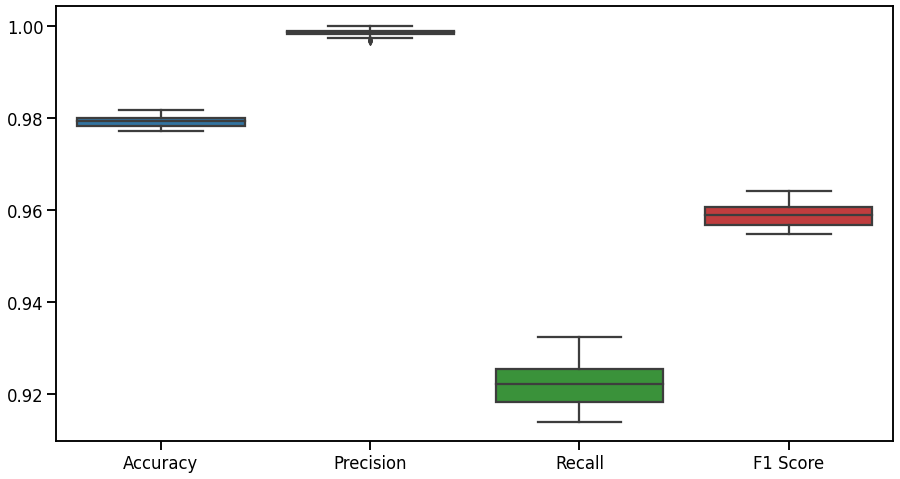

In [6]:
#g1
#probamos un arbol con 50 semillas random

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt


n_seeds = 50
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):
  # volvemos a dividir el dataset en  entrenamiento 80% y validación 20%
  x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed,
                                                      stratify=y_train)
  arbol_sklearn = DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=30, ccp_alpha=0)
  arbol_sklearn.fit(x_train_,y_train_)

  y_pred_val = arbol_sklearn.predict(x_val)
  accs.append(accuracy_score(y_val,y_pred_val))
  precisions.append(precision_score(y_val,y_pred_val))
  recalls.append(recall_score(y_val,y_pred_val))
  f1s.append(f1_score(y_val,y_pred_val))

all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

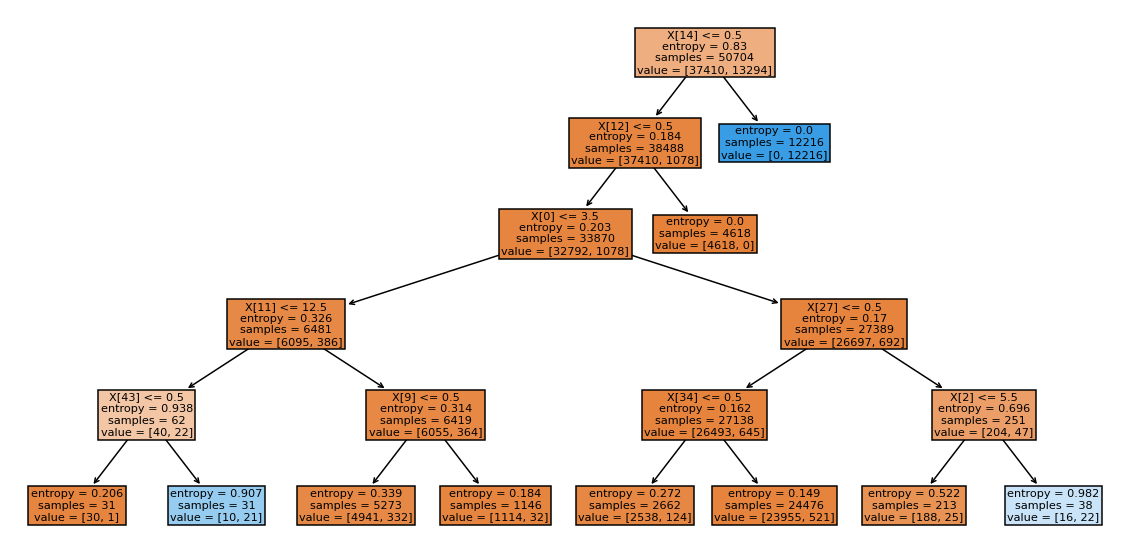

In [7]:
# vemos el ultimo arbol generado ( no lo piden, es para ver que hizo...)
plt.figure(figsize=(20,10))
plot_tree(arbol_sklearn,filled=True);

In [9]:
df_booking[features].columns[14]

'cancel_days_before_arrival'

In [11]:
# vemos los atritbutos mas importantes ordenados por atributos
a = pd.DataFrame(arbol_sklearn.feature_importances_, df_booking[features].columns,)
a.sort_values(by=0, ascending=False)


,0
cancel_days_before_arrival,0.984487
required_car_parking_spaces,0.005678
lead_time,0.003463
continent_Africa,0.002367
agent_b,0.001087
adr,0.001001
stays_in_week_nights,0.000736
market_seg_Direct,0.000666
booking_changes,0.000515
cust_type_Group,0.000000


In [12]:
# g2
# armamos de nuevo el arbol con 50 folds de croos validation y variando con los hiperparametros
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,10)),
               'ccp_alpha':np.linspace(0,0),
               'min_samples_leaf':list(range(1,30))}

kfoldcv = StratifiedKFold(n_splits=5)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(recall_score)
randomcv = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,scoring=scorer_fn,cv=kfoldcv,n_iter=50)
randomcv.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0...
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [16]:
# vemos los resultados del proceso

pd.DataFrame(randomcv.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.158154,0.008368,0.007684,0.000214,17,4,entropy,0,"{'min_samples_leaf': 17, 'max_depth': 4, 'crit...",0.925670,0.918447,0.921179,0.920578,0.913057,0.919786,0.004105,35
1,0.185767,0.002152,0.007663,0.000112,18,5,gini,0,"{'min_samples_leaf': 18, 'max_depth': 5, 'crit...",0.927174,0.921156,0.924489,0.923285,0.916366,0.922494,0.003629,16
2,0.185935,0.006295,0.007678,0.000244,14,5,gini,0,"{'min_samples_leaf': 14, 'max_depth': 5, 'crit...",0.927174,0.921156,0.924489,0.923285,0.915764,0.922374,0.003835,18
3,0.129755,0.003704,0.007621,0.000269,15,3,gini,0,"{'min_samples_leaf': 15, 'max_depth': 3, 'crit...",0.926873,0.919651,0.921781,0.922383,0.913057,0.920749,0.004508,33
4,0.156592,0.005864,0.007613,0.000102,17,4,entropy,0,"{'min_samples_leaf': 17, 'max_depth': 4, 'crit...",0.925670,0.918447,0.921179,0.920578,0.913057,0.919786,0.004105,35


In [17]:
# buscamos los paramtros del mejor arbol
randomcv.best_params_

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 22}

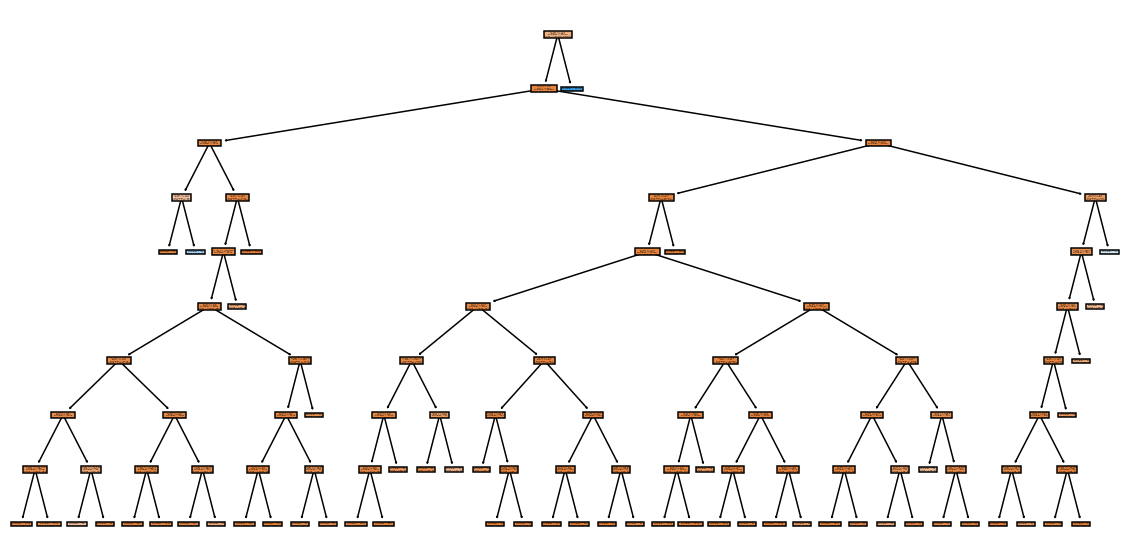

In [18]:
# ejecutamos el mejor arbol
# y lo graficamos
arbol_sklearn = DecisionTreeClassifier(criterion='gini',max_depth=9,min_samples_leaf=22, ccp_alpha=0)
arbol_sklearn.fit(x_train_,y_train_)

y_pred_val = arbol_sklearn.predict(x_val)

plt.figure(figsize=(20,10))
plot_tree(arbol_sklearn,filled=True);



In [20]:
# vamos los atributos mas importantes del mejor arbol
a = pd.DataFrame(arbol_sklearn.feature_importances_, df_booking[features].columns,)
a.sort_values(by=0, ascending=False)

,0
cancel_days_before_arrival,0.993283
lead_time,0.001093
stays_in_week_nights,0.001016
adr,0.000853
market_seg_Direct,0.000757
continent_Africa,0.000724
adr_por_persona,0.000709
required_car_parking_spaces,0.000561
agent_b,0.000174
booking_changes,0.000121


In [0]:
# algoritmo que hay que usar para el ultimo punto

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
